In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from sklearn.decomposition import NMF
import math as Math

# Exercise 1: Recommender Dataset

In [2]:
data=pd.read_csv(r"E:\Documents\University of Hildesheim\Machine learning lab\lab10\ml-100k\u.data",sep=r"\s+",
                 names=["userId","itemId","rating","timestamp"])
data.head()

,userId,itemId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


### Encoding female as 1 and male as 0

In [3]:
userdata=pd.read_csv(r"E:\Documents\University of Hildesheim\Machine learning lab\lab10\ml-100k\u.user",
                     names=["userId","age","gender","occupation","zipcode"],sep="|")
userdata=userdata.replace(['F','M'],[1,0])
userdata.head()

,userId,age,gender,occupation,zipcode
0,1,24,0,technician,85711
1,2,53,1,other,94043
2,3,23,0,writer,32067
3,4,24,0,technician,43537
4,5,33,1,other,15213


In [4]:
itemdata=pd.read_csv(r"E:\Documents\University of Hildesheim\Machine learning lab\lab10\ml-100k\u.item",names=["movieid", "movietitle","releasedate","videoreleasedate",
              "IMDbURL","unknown","Action","Adventure", "Animation",
              "Children's","Comedy", "Crime", "Documentary","Drama","Fantasy",
              "Film-Noir","Horror","Musical", "Mystery","Romance","Sci-Fi",
              "Thriller", "War", "Western"],sep="|",encoding="ISO-8859-1")
itemdata.head()

,movieid,movietitle,releasedate,videoreleasedate,IMDbURL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


## Finding 1: After analyzing the bar plot we found out that students watch more movies than any other occupants.

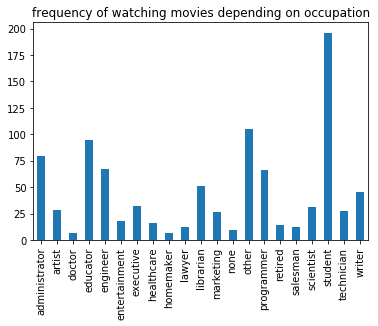

In [5]:
bplot=userdata["occupation"].value_counts()
bplot=bplot.sort_index()
bplot.plot(kind='bar')
plt.title("frequency of watching movies depending on occupation")
plt.show()

## Finding 2: After analyzing the barplot we can observe that the most watched movie is type drama

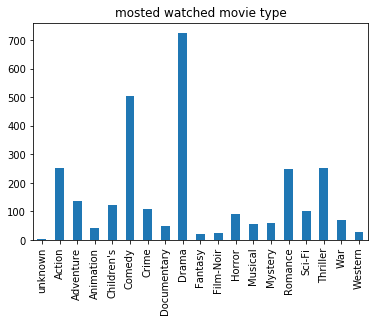

In [6]:
freq_array=pd.Series()
for column in itemdata.columns[5:]:
    freq_array[column]=sum(itemdata[column].values)
bplot=freq_array
bplot.plot(kind='bar')
plt.title("mosted watched movie type")
plt.show()

## Finding 3: After Analyzing the histogram we can see that the highest rating is 4 for the movies

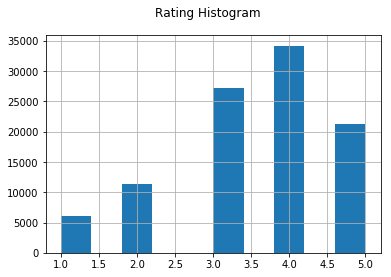

In [7]:
data["rating"].hist()
plt.suptitle("Rating Histogram")
plt.show()

## Finding 4: After Analyzing the histogram we can see that males watch more movies than females

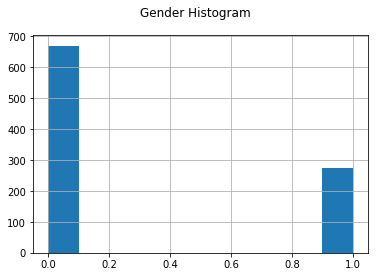

In [8]:
userdata["gender"].hist()
plt.suptitle("Gender Histogram")
plt.show()

# Exercise 2 : Implement basic matrix factorization (MF) technique for recommender systems

In [9]:
def Matrixfact(matrix,k,alpha,beta,epoch,sample,testsample):
    n_users,n_items=matrix.shape
    
    P=pd.DataFrame(np.random.normal(scale=1./k, size=( n_users,k)),columns=[0,1],
                   index=sample['userId'].unique())
    Q=pd.DataFrame(np.random.normal(scale=1./k,size=( n_items,k)),columns=[0,1],
                   index=sample['itemId'].unique())
    user_bais=pd.DataFrame(0,columns=[0],
                   index=sample['userId'].unique())
    item_bais=pd.DataFrame(0,columns=[0],
                   index=sample['itemId'].unique())
    sample=sample.values
    matrix=matrix.values
    bais=np.mean(matrix[np.where(matrix!=0)])
    
    rmse=[]
    for i in range(epoch):
        np.random.shuffle(sample)
        P,Q,user_bais,item_bais=sgd(sample,P,Q,user_bais,item_bais,bais,alpha,beta)
        error=errorRMSE(matrix,bais,user_bais,item_bais,P,Q,testsample)
        rmse.append(error)
        if (i+1)%10 == 0:
            print("iteration:",i,"error",error)
    return rmse,P,Q,user_bais,item_bais,bais

In [10]:
def errorRMSE (matrix,bais,user_bais,item_bais,P,Q,testsample):
    pred=full_matrix(bais,user_bais,item_bais,P,Q)
    yhat,y=predict(matrix,pred,testsample)
    return RMSE(y['rating'],yhat)

In [11]:
def full_matrix(bais,user_bais,item_bais,P,Q):
    user_item_bais=np.zeros((len(user_bais),len(item_bais)))
    for i in range (0,len(user_bais)):
        for j in range (0,len(item_bais)):
            user_item_bais[i][j]=user_bais.iloc[i][0]+item_bais.iloc[j][0]
    return bais + user_item_bais + P.dot(Q.T)

In [12]:
def sgd(sample,P,Q,user_bais,item_bais,bais,alpha,beta):
    for i,j,r in sample:
        pred=get_rating(P,Q,i,j,user_bais,item_bais,bais)
        e=(r-pred)
        
        user_bais.loc[i] += alpha * (e[0]- beta * user_bais.loc[i])
        item_bais.loc[j] += alpha * (e[0]- beta * item_bais.loc[j])
        
        P.loc[i] += alpha * (e[0] * Q.loc[j]-beta * P.loc[i])
        Q.loc[j] += alpha * (e[0] * P.loc[i]-beta * Q.loc[j])
    
    return P,Q,user_bais,item_bais
        

In [13]:
def get_rating (P,Q,user,item,user_bais,item_bais,bais):
    pred=bais+user_bais.loc[user] + item_bais.loc[item]+P.loc[user].dot(Q.loc[item].T)
    return pred

In [14]:
def predict(matrix_,matrix,test):
    yhat=[]
    dval=[]
    for i in range (0,len(test)):
        flag=1
        if(test.iloc[i]['userId'] in matrix.index):
            if(test.iloc[i]['itemId'] in matrix.columns):
                flag=0
        if (flag):
            dval.append(i)
        else:
            yhat.append(matrix[test.iloc[i]['itemId']][test.iloc[i]['userId']])
    return yhat,test.drop(test.index[dval])

In [15]:
def RMSE(y,yhat):
    rmse =Math.sqrt(np.sum(pow((y-yhat),2))/len(y))
    return rmse

In [16]:
def data_k_divide(data,k):
    k_size=Math.floor(len(data)/k)
    k_data=[] 
    c=0
    for i in range (0,k):
        data_set=pd.DataFrame(data.head(0))
        for j in range(i*k_size,(i*k_size)+k_size):
            data_set=data_set.append(data.iloc[j])
            c=c+1
        k_data.append(data_set)
        
    #adding datas which are remaining at the end of k division
    for j in range(c,len(data)):
        k_data[k-1]=k_data[k-1].append(data.iloc[j])
    return k_data

def k_data_train_test(x,k):
    k_folded_data=[]
    for i in range(0,k):
        x_test=x[i]
    
        x_train=pd.DataFrame()
        
        for j in range(0,k):
            if i!=j:
                x_train=x_train.append(x[j])
                
        final_data=dict([('x_train',x_train),('x_test',x_test)])
        k_folded_data.append(final_data)
    return k_folded_data
    
def kfold(x_train,k,alpha,lamda):
    rmse=[]
    x_train_k=data_k_divide(x_train,k)
    kdata=k_data_train_test(x_train_k,k)
    for i in range(0,k):
        rMatrix=kdata[i]['x_train'].pivot(index='userId',columns='itemId',values='rating')
        rMatrix=rMatrix.replace(np.nan,0)
        rmsearr,P,Q,user_bais,item_bais,bais=Matrixfact(rMatrix,2,alpha,lamda,1,kdata[i]['x_train'][["userId","itemId","rating"]],
                                                        kdata[i]['x_test'][["userId","itemId","rating"]])
        rmse.append(sum(rmsearr)/len(rmsearr))
    return sum(rmse)/k

In [17]:
def gridsearch(alpha,lamda):
    comb=[]
    for i in range(0,len(alpha)):
        for k in range(0,len(lamda)):
            comb.append(dict([('alpha',alpha[i]),('lamda',lamda[k])]))
    return comb

In [18]:
alpha=[0.1,0.0000001]
lamda=[0.1,0.0001]
grid=gridsearch(alpha,lamda)

for i in range (0,len(grid)):
    rmse=kfold(data,3,grid[i]["alpha"],grid[i]["lamda"])
    print("testrmse:" ,rmse,"for k values of :",grid[i])

testrmse: 0.9866806359944896 for k values of : {'alpha': 0.1, 'lamda': 0.1}
testrmse: 4.294415493862302e+51 for k values of : {'alpha': 0.1, 'lamda': 0.0001}
testrmse: 1.1810406190458984 for k values of : {'alpha': 1e-07, 'lamda': 0.1}
testrmse: 1.1812300027031035 for k values of : {'alpha': 1e-07, 'lamda': 0.0001}


### The best RMSE score is 0.986 for K values of : {'alpha': 0.1, 'lamda': 0.1}